In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nfl-big-data-bowl-2026-prediction/test_input.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/test.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/nfl_inference_server.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/nfl_gateway.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/__init__.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/templates.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/base_gateway.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/relay.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/kaggle_evaluation.proto
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/__init__.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/generated/kaggle_evaluation_pb2.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/generated/kaggle_evaluati

### Variables de entrada (features)

Posición actual del jugador:

x_in → Coordenada en el eje X

y_in → Coordenada en el eje Y
Estas variables describen el punto exacto donde se encuentra el jugador en el instante actual.

Velocidad en cada eje:

vel_x → Velocidad en el eje X

vel_y → Velocidad en el eje Y
Representan la rapidez y dirección del movimiento en cada eje, lo cual es fundamental para predecir desplazamientos futuros.

Aceleración en cada eje:

acc_x → Aceleración en el eje X

acc_y → Aceleración en el eje Y
Permiten describir cambios súbitos en la velocidad del jugador, útiles para anticipar curvas o frenados.

Variables categóricas adicionales (si aparecían en tu dataset):

rol → Tipo de jugador u ocupación dentro del juego.

team → Equipo o agrupación.

### Variables de salida (target)

El objetivo del modelo es predecir la posición futura del jugador, usualmente en el siguiente “frame” o paso temporal. Por lo tanto, las variables de salida son:

x_out → Coordenada futura en el eje X

y_out → Coordenada futura en el eje Y

Estas variables representan el punto hacia el cual el jugador se desplaza inmediatamente después del instante actual. El modelo aprende la relación dinámica entre la posición presente, su velocidad, aceleración y contexto, con el fin de anticipar este movimiento.

### - Preparación de los datos 
### - Procedimientos de codificación de valores faltantes y variables categóricas
### - Preprocesamiento y limpieza de datos.

In [8]:
#Librerías
import numpy as np
import pandas as pd
import glob, os
import pickle
from sklearn.preprocessing import LabelEncoder

# Carga de la base de datos 
def load_training_data(data_path='/kaggle/input/nfl-big-data-bowl-2026-prediction/train'):
    """
    Lee todos los archivos input_2023_w*.csv y output_2023_w*.csv existentes y los concatena.
    Devuelve (inputs_df, outputs_df).
    """
    input_files = sorted(glob.glob(os.path.join(data_path, 'input_2023_w*.csv')))
    output_files = sorted(glob.glob(os.path.join(data_path, 'output_2023_w*.csv')))

    if len(input_files) == 0:
        raise FileNotFoundError(f"No se encontraron archivos input en {data_path}")

    input_dfs = []
    output_dfs = []
    for f in input_files:
        input_dfs.append(pd.read_csv(f))
    for f in output_files:
        output_dfs.append(pd.read_csv(f))

    inputs = pd.concat(input_dfs, ignore_index=True)
    outputs = pd.concat(output_dfs, ignore_index=True) if output_dfs else pd.DataFrame()
    print(f"Loaded {len(input_files)} input files, {len(output_files)} output files.")
    print("Inputs shape:", inputs.shape)
    print("Outputs shape:", outputs.shape)
    return inputs, outputs

# ---------- Encoding categóricas (con guardado) ----------
def encode_categorical(df, categorical_cols=None, encoders=None, save_path=None):
    """
    Si `encoders` es None: fit transforma y devuelve encoders.
    Si `encoders` dado: aplica transform (manejo de unseen -> 'NA' o índice 'unknown').
    Devuelve df_encoded, mappings, encoders
    """
    df = df.copy()
    if categorical_cols is None:
        categorical_cols = ['play_direction', 'player_position', 'player_side', 'player_role']

    mappings = {}
    if encoders is None:
        encoders = {}

    for col in categorical_cols:
        df[col] = df[col].fillna('NA').astype(str)
        if col not in encoders:
            le = LabelEncoder()
            le.fit(df[col].values)
            encoders[col] = le
        else:
            le = encoders[col]
        # Transform: manejar categorias desconocidas mapeando a 'NA' si necesario
        vals = df[col].values
        # Si hay categorías nuevas no vistas por el encoder, reemplazarlas por 'NA' antes de transformar
        known = set(le.classes_)
        vals_fixed = [v if v in known else 'NA' for v in vals]
        df[col] = le.transform(vals_fixed)
        mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

    if save_path:
        with open(save_path, 'wb') as f:
            pickle.dump(encoders, f)

    return df, mappings, encoders

# ---------- Cleaning con chequeos ----------
def dataset_cleaning(X, Y, drop_cols=None):
    """
    Hace merge controlado entre X e Y. 
    """
    df = X.copy()
    if drop_cols is None:
        drop_cols = ['player_birth_date', 'player_name', 'nfl_id', 'game_id',
                     'num_frames_output', 'player_to_predict', 'player_height']

    # Comprobación básica de claves
    required_keys = ['game_id', 'play_id', 'nfl_id', 'frame_id']
    for k in required_keys:
        if k not in df.columns:
            raise KeyError(f"Key {k} not found in input dataframe")
        if k not in Y.columns:
            raise KeyError(f"Key {k} not found in output dataframe")

    merged = df.merge(Y, on=required_keys, how='inner', suffixes=('_in', '_out'))
    if merged.empty:
        raise ValueError("Merged dataframe is empty — check keys and frame alignment between X and Y")

    features = merged.drop(columns=['x_out', 'y_out'], errors='ignore')
    targets = merged[['x_out', 'y_out']].copy()

    # Drop safely (si no existe, ignore)
    features = features.drop(columns=[c for c in drop_cols if c in features.columns], errors='ignore')
    return features, targets

# ---------- Feature engineering segura ----------
def new_data(df):
    df = df.copy()
    # Verificar columnas necesarias
    required = ['x_in','y_in','ball_land_x','ball_land_y','player_weight','s']
    for c in required:
        if c not in df.columns:
            print(f"Warning: columna {c} no encontrada en df. No se creará la feature que dependa de ella.")
    if all(c in df.columns for c in ['x_in','y_in','ball_land_x','ball_land_y']):
        df['dist_ball'] = np.hypot(df['x_in'] - df['ball_land_x'], df['y_in'] - df['ball_land_y'])
    if 'player_weight' in df.columns and 's' in df.columns:
        # Convertir libras a kg si el dataset usa lb
        # df['player_weight_kg'] = df['player_weight'] * 0.453592
        df['momentum'] = df['player_weight'] * df['s']
    return df


In [9]:
X, Y = load_training_data()
print(f"Input shape:{X.shape} , Output shape:{Y.shape}")

Loaded 18 input files, 18 output files.
Inputs shape: (4880579, 23)
Outputs shape: (562936, 6)
Input shape:(4880579, 23) , Output shape:(562936, 6)


In [10]:
X2, mappings, encoders = encode_categorical(X)

train_clean, targets = dataset_cleaning(X2, Y)
train_full = new_data(train_clean)

# Información de la base de datos
train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560426 entries, 0 to 560425
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   play_id                   560426 non-null  int64  
 1   frame_id                  560426 non-null  int64  
 2   play_direction            560426 non-null  int64  
 3   absolute_yardline_number  560426 non-null  int64  
 4   player_weight             560426 non-null  int64  
 5   player_position           560426 non-null  int64  
 6   player_side               560426 non-null  int64  
 7   player_role               560426 non-null  int64  
 8   x_in                      560426 non-null  float64
 9   y_in                      560426 non-null  float64
 10  s                         560426 non-null  float64
 11  a                         560426 non-null  float64
 12  dir                       560426 non-null  float64
 13  o                         560426 non-null  f

### Análisis Exploratorio

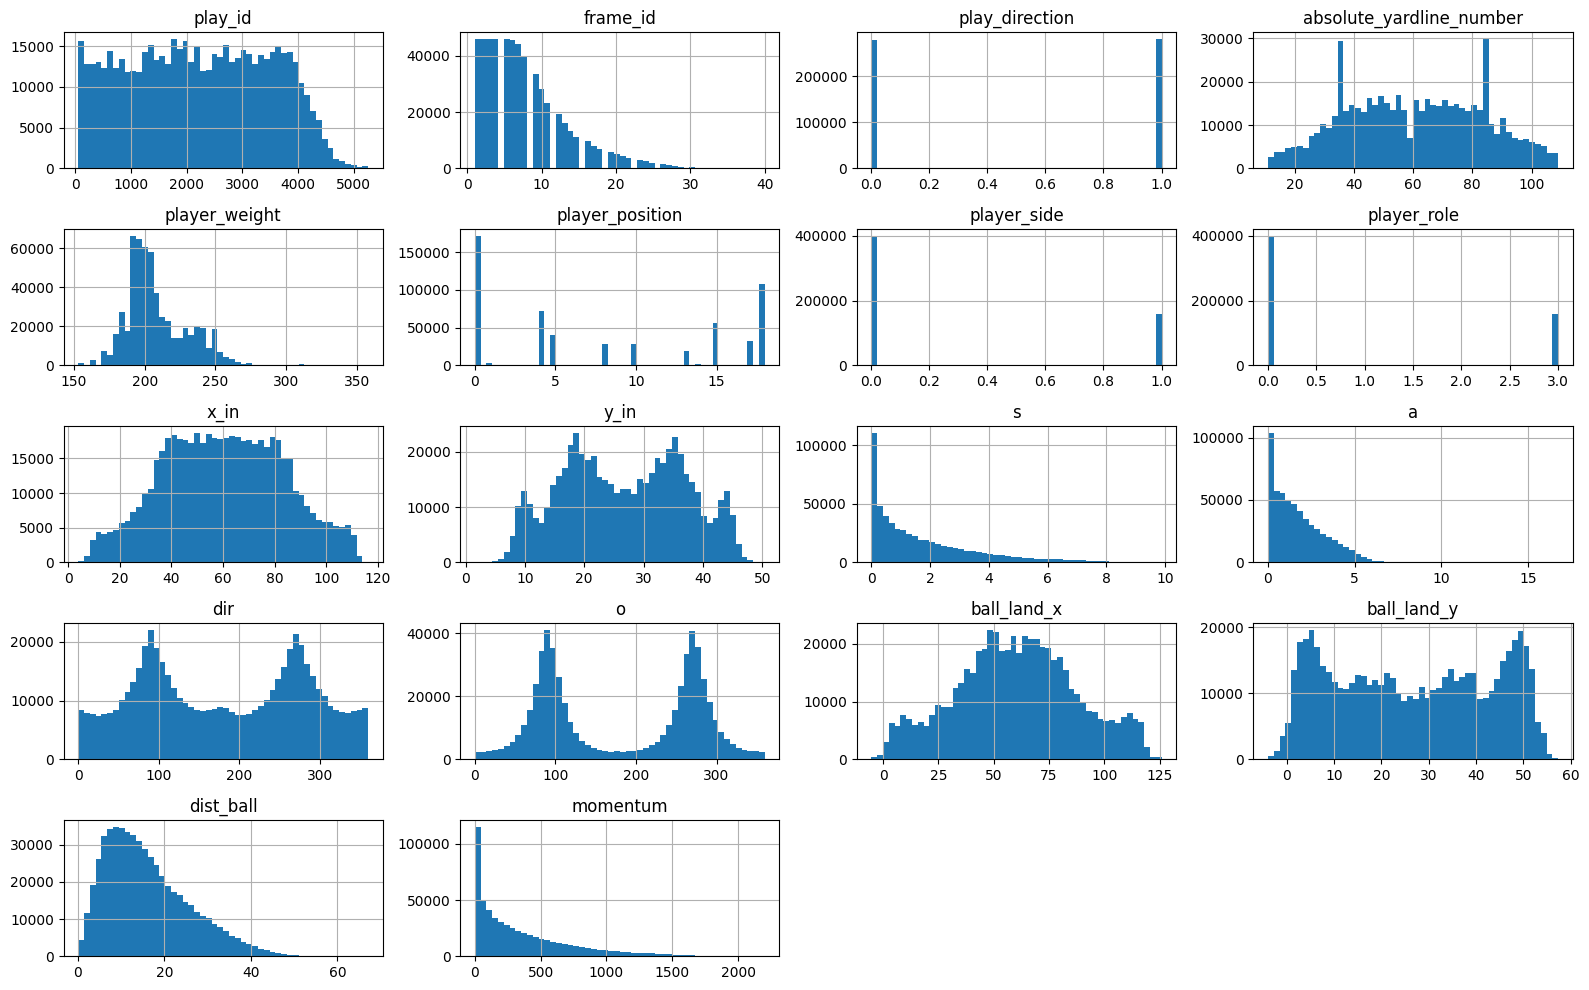

In [11]:
import matplotlib.pyplot as plt

train_full.hist(bins=50, figsize=(16,10))
plt.tight_layout()
plt.show()

Posición de los jugadores

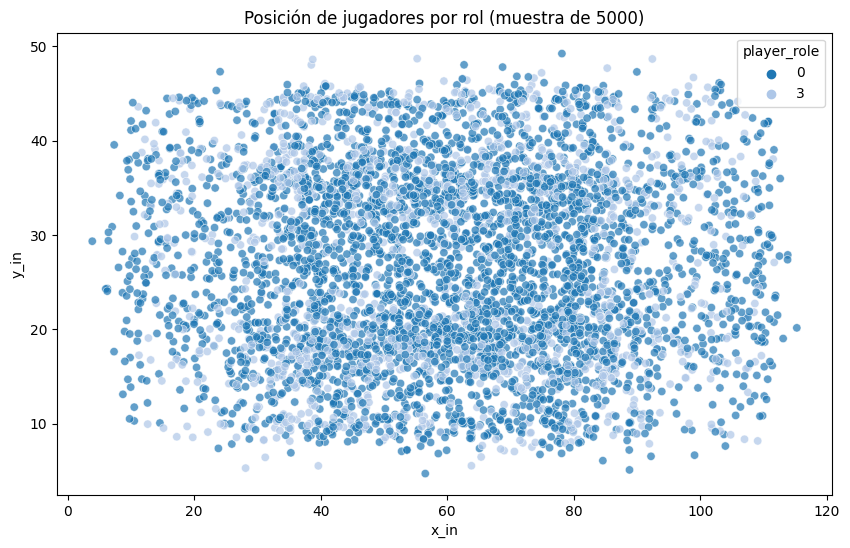

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sample = train_full.sample(n=5000, random_state=42)  # 5000 puntos

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=sample,
    x="x_in",
    y="y_in",
    hue="player_role",
    alpha=0.7,
    palette="tab20"
)
plt.title("Posición de jugadores por rol (muestra de 5000)")
plt.show()




Mapa de calor

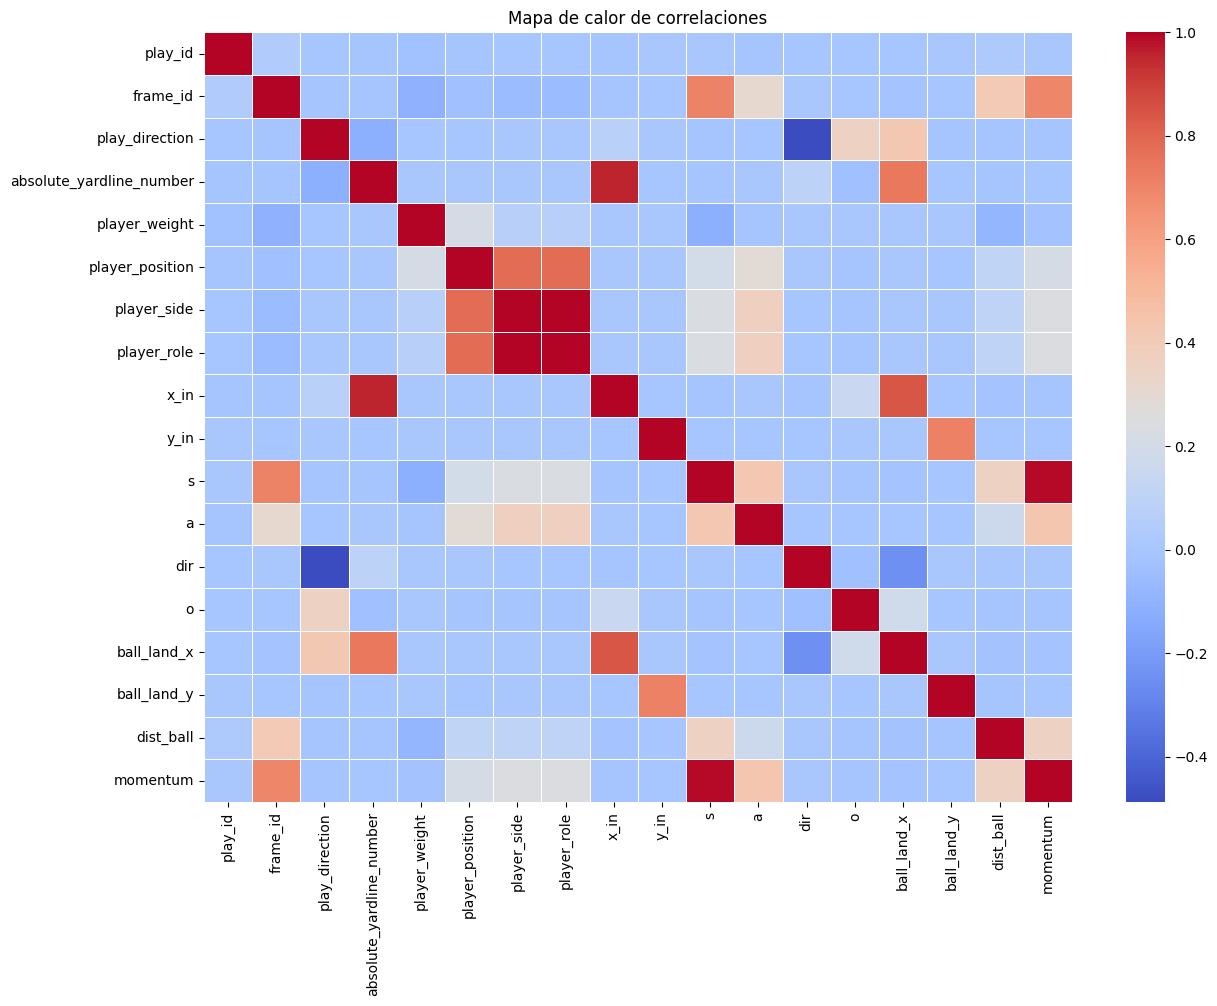

In [13]:
numeric_data = train_full.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    annot=False,
    cmap="coolwarm",
    linewidths=0.5
)

plt.title("Mapa de calor de correlaciones")
plt.show()


## Modelo de Entrenamiento: 
### Arquitectura usada: TabNet

### Justificación: 

Se seleccionó la arquitectura TabNet, un modelo de aprendizaje profundo diseñado específicamente para datos tabulares (numéricos y categóricos), como los presentes en el Big Data Bowl.

TabNet combina transformadores de características con mecanismos de atención secuencial (decision steps), permitiendo que el modelo aprenda qué variables son relevantes en cada etapa del procesamiento.

Esta arquitectura supera a las redes densas tradicionales porque:
(1) utiliza sparsity regularization, lo que mejora la capacidad del modelo de enfocarse en variables importantes como velocidad, rol, posición y momentum;
(2) es interpretable, permitiendo extraer importancia de características;
(3) maneja muy bien datos mezclados (numéricos + categóricos);
(4) requiere menos preprocesamiento que modelos clásicos;
(5) captura relaciones no lineales de forma eficiente.

Se realizó además una búsqueda de hiperparámetros con Optuna, optimizando dimensiones internas (n_d, n_a), número de pasos de decisión, sparsity y tasa de aprendizaje. Esto garantiza una arquitectura ajustada al problema.

In [18]:
!pip install pytorch-tabnet

In [14]:
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

from pytorch_tabnet.tab_model import TabNetRegressor
import torch
import joblib  # para guardar scaler/encoders
import optuna  # opcional

In [15]:
#Identificar variables numéricas y categóricas y verificar valores en NaN para que no haya problemas con TabNet
# Ejemplo: columnas candidatas
cols_all = list(train_full.columns)
print(cols_all)

# Selecciona features numéricas y categóricas
numerical_cols = ['x_in', 'y_in', 's', 'a', 'dir', 'o', 'ball_land_x', 'ball_land_y', 'dist_ball', 'momentum', 'absolute_yardline_number']
categorical_cols = ['play_direction', 'player_position', 'player_side', 'player_role']

# Verifica NaNs
print(train_full[numerical_cols + categorical_cols].isna().sum())

# Si player_weight estaba en libras y usaste momentum, opcional: convertir en masa (kg)
# Si ya tienes momentum calculado con lb, puedes recalcular:
# train_full['player_weight_kg'] = train_full['player_weight'] * 0.453592
# train_full['momentum'] = train_full['player_weight_kg'] * train_full['s']


['play_id', 'frame_id', 'play_direction', 'absolute_yardline_number', 'player_weight', 'player_position', 'player_side', 'player_role', 'x_in', 'y_in', 's', 'a', 'dir', 'o', 'ball_land_x', 'ball_land_y', 'dist_ball', 'momentum']
x_in                        0
y_in                        0
s                           0
a                           0
dir                         0
o                           0
ball_land_x                 0
ball_land_y                 0
dist_ball                   0
momentum                    0
absolute_yardline_number    0
play_direction              0
player_position             0
player_side                 0
player_role                 0
dtype: int64


In [16]:
#Codificar categorías para que TabNet embeddings y atención sobre esas variables
encoders = {}
cat_idxs = []
cat_dims = []
processed = train_full.copy()

for c in categorical_cols:
    le = LabelEncoder()
    processed[c] = le.fit_transform(processed[c])
    encoders[c] = le
    cat_idxs.append(processed.columns.get_loc(c))  # índice de columna en dataframe procesado
    cat_dims.append(len(le.classes_))

# guardar encoders
joblib.dump(encoders, "encoders.joblib")
print("cat_idxs:", cat_idxs)
print("cat_dims:", cat_dims)

## Conversión a Numpy 
# Features (asegúrate del orden: cat indices usan posiciones relativas a X)
feature_cols = numerical_cols + categorical_cols  # si quieres otro orden, actualiza cat_idxs accordingly
X = processed[feature_cols].values.astype(np.float32)
y = targets[['x_out', 'y_out']].values.astype(np.float32)  # shape (N, 2)
print("X shape:", X.shape)
print("y shape:", y.shape)



cat_idxs: [2, 5, 6, 7]
cat_dims: [2, 17, 2, 2]
X shape: (560426, 15)
y shape: (560426, 2)


In [17]:
#División de la base de datos en entrenamiento y evaluación (Split train / val / test y escalado)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Escalar las variables numéricas
# identifica índices de num cols dentro de X
num_idx = [feature_cols.index(c) for c in numerical_cols]

scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[:, num_idx])
X_val_num = scaler.transform(X_val[:, num_idx])
X_test_num = scaler.transform(X_test[:, num_idx])

# reconstruir Xs con columnas numéricas escaladas y las categóricas intactas
def rebuild(X_raw, X_num_scaled):
    X_copy = X_raw.copy()
    X_copy[:, num_idx] = X_num_scaled
    return X_copy

X_train_scaled = rebuild(X_train, X_train_num)
X_val_scaled = rebuild(X_val, X_val_num)
X_test_scaled = rebuild(X_test, X_test_num)

# guardar scaler
joblib.dump(scaler, "scaler.joblib")


['scaler.joblib']

In [19]:
import optuna
import numpy as np
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

In [ ]:
def objective(trial):

    # === Hiperparámetros ===
    n_d = trial.suggest_int("n_d", 8, 64)
    n_a = trial.suggest_int("n_a", 8, 64)
    n_steps = trial.suggest_int("n_steps", 3, 10)
    gamma = trial.suggest_float("gamma", 1.0, 3.0)
    lambda_sparse = trial.suggest_float("lambda_sparse", 1e-6, 1e-3, log=True)
    momentum = trial.suggest_float("momentum", 0.01, 0.4)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [256, 512])
    

    # === Modelo ===
    model = TabNetRegressor(
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        gamma=gamma,
        lambda_sparse=lambda_sparse,
        momentum=momentum,
        optimizer_fn=torch.optim.Adam,
        optimizer_params={"lr": lr},
        mask_type="entmax",
        device_name="cuda",        
        verbose=0
    )

    # === Entrenamiento ===
    model.fit(
        X_train=X_train_scaled,
        y_train=y_train,
        eval_set=[(X_val_scaled, y_val)],
        eval_metric=["mse"],
        max_epochs=20,            
        patience=10,               
        batch_size=batch_size,      
        virtual_batch_size=128
    )

    # === Evaluación ===
    preds = model.predict(X_val_scaled).reshape(-1)
    mse = np.mean((preds - y_val.reshape(-1)) ** 2)

    return mse


# === Optimización ===
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30, timeout=3600)  

print("Mejores hiperparámetros encontrados:")
print(study.best_params)


In [21]:
best_params = {'n_d': 52, 'n_a': 13, 'n_steps': 5, 'gamma': 2.4471097212428967, 'lambda_sparse': 0.00023798943021161403, 'momentum': 0.3817635749262123, 'lr': 0.0013755143976526467, 'batch_size': 512}

final_model = TabNetRegressor(
    n_d=best_params["n_d"],
    n_a=best_params["n_a"],
    n_steps=best_params["n_steps"],
    gamma=best_params["gamma"],
    lambda_sparse=best_params["lambda_sparse"],
    momentum=best_params["momentum"],
    optimizer_fn=torch.optim.Adam,
    optimizer_params={"lr": best_params["lr"]},
    mask_type="entmax",
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [22]:
final_model.fit(
    X_train=X_train_scaled,
    y_train=y_train,
    eval_set=[(X_val_scaled, y_val)],
    eval_metric=["mse"],
    max_epochs=20,
    patience=10,
    batch_size=256,
    virtual_batch_size=128
)

epoch 0  | loss: 247.36403| val_0_mse: 24.198190689086914|  0:00:50s
epoch 1  | loss: 24.38844| val_0_mse: 18.588239669799805|  0:01:41s
epoch 2  | loss: 20.992  | val_0_mse: 17.23723030090332|  0:02:32s
epoch 3  | loss: 19.33928| val_0_mse: 16.181360244750977|  0:03:22s
epoch 4  | loss: 18.33181| val_0_mse: 15.35204029083252|  0:04:13s
epoch 5  | loss: 17.78755| val_0_mse: 15.619549751281738|  0:05:04s
epoch 6  | loss: 17.39098| val_0_mse: 15.593130111694336|  0:05:55s
epoch 7  | loss: 16.97623| val_0_mse: 15.016949653625488|  0:06:46s
epoch 8  | loss: 16.79228| val_0_mse: 15.183130264282227|  0:07:37s
epoch 9  | loss: 16.56007| val_0_mse: 15.233489990234375|  0:08:27s
epoch 10 | loss: 16.23209| val_0_mse: 14.487099647521973|  0:09:17s
epoch 11 | loss: 16.12204| val_0_mse: 14.344490051269531|  0:10:08s
epoch 12 | loss: 16.03854| val_0_mse: 15.243209838867188|  0:10:58s
epoch 13 | loss: 15.88837| val_0_mse: 14.161879539489746|  0:11:49s
epoch 14 | loss: 15.87243| val_0_mse: 14.67903995

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [23]:
final_model.save_model("tabnet_best.zip")

Successfully saved model at tabnet_best.zip.zip


'tabnet_best.zip.zip'

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def error_calculation(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred)
    }


In [28]:
y_pred = final_model.predict(X_test_scaled)
errores = error_calculation(y_test, y_pred)


errores = error_calculation(y_test, y_pred)

for k, v in errores.items():
    print(f"{k}: {v:.4f}")


MAE: 2.6834
MSE: 13.8525
RMSE: 3.7219
R2: 0.9500
